<a href="https://colab.research.google.com/github/ayoubbensakhria/finance_algo/blob/master/FXPROBOT_v2_Trained_pairs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --user -U nltk
!pip install feedparser
!pip install yfinance

     |████████████████████████████████| 1.5 MB 29.7 MB/s 
     |████████████████████████████████| 748 kB 55.3 MB/s 
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
     |████████████████████████████████| 81 kB 6.2 MB/s 
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6066 sha256=86a01d8aaa51d8fae9f3bfa3351b5b998be431714f63a92f260bf5e67c79feb1
  Stored in directory: /root/.cache/pip/wheels/73/ad/a4/0dff4a6ef231fc0dfa12ffbac2a36cebfdddfe059f50e019aa
Successfully built sgmllib3k
     |████████████████████████████████| 63 kB 1.1 MB/s 
     |████████████████████████████████| 6.4 MB 41.5 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [2]:
import math
import nltk
import feedparser
import numpy as np
import pandas as pd
import warnings
import yfinance as yf
import dateutil.parser
from termcolor import colored as cl
from datetime import date, timedelta, datetime
from matplotlib import pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from urllib.request import urlopen, Request
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (24, 12)
plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')
nltk.downloader.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


True

In [3]:
from joblib import load
# available symbols : EURUSD, GBPUSD, USDJPY, USDCAD, USDCHF, AUDUSD, NZDUSD, EURJPY, GBPJPY, GOLd
symbols = ["EURUSD","GBPUSD", "USDCAD", "EURJPY", "GBPJPY", "NZDUSD", "AUDUSD", "EURGBP", "GC=F"]
models = {}
for symbol in symbols:
  models[symbol] =  load('/content/drive/MyDrive/data/FX{symbol}.joblib'.format(symbol=symbol.replace("=F", "")))
  print ('Model FX{symbol} Loaded'.format(symbol = symbol))

Model FXEURUSD Loaded
Model FXGBPUSD Loaded
Model FXUSDCAD Loaded
Model FXEURJPY Loaded
Model FXGBPJPY Loaded
Model FXNZDUSD Loaded
Model FXAUDUSD Loaded
Model FXEURGBP Loaded
Model FXGC=F Loaded


In [4]:
# constants
period = 14
macd_slow = 26*8
macd_fast = 12*8
macd_smooth = 9*8
rsi_period = 14

def get_macd(df, slow, fast, smooth):
    exp1_8 = df['Close'].ewm(span = fast, adjust = False).mean()
    exp2_8 = df['Close'].ewm(span = slow, adjust = False).mean()
    # 4Hour MACD
    df['macd8'] = pd.DataFrame(exp1_8 - exp2_8)
    df['signal8']  = pd.DataFrame(df['macd8'].ewm(span = smooth, adjust = False).mean())
    df['hist8'] = pd.DataFrame(df['macd8'] - df['signal8'])
    return df

def get_rsi(df, lookback):
    ret = df['Close'].diff()
    up = []
    down = []
    for i in range(len(ret)):
        if ret[i] < 0:
            up.append(0)
            down.append(ret[i])
        else:
            up.append(ret[i])
            down.append(0)
    up_series = pd.Series(up)
    down_series = pd.Series(down).abs()
    up_ewm = up_series.ewm(com = lookback - 1, adjust = False).mean()
    down_ewm = down_series.ewm(com = lookback - 1, adjust = False).mean()
    rs = up_ewm/down_ewm
    rsi = 100 - (100 / (1 + rs))
    rsi_df = pd.DataFrame(rsi).rename(columns = {0:'rsi'}).set_index(df['Close'].index)
    rsi_df = rsi_df.dropna(0)
    df['rsi'] = rsi_df[3:]
    return df

In [23]:
# filter features
feature_names = ['Date', 'Open', 'Close', 'High', 'Low', 'Volume', 'macd8', 'signal8',
       'hist8', 'rsi', 'max_price', 'min_price',
       'tsignal', 'atsignal', 'moment', 'Adj close']
non_features = ['tsignal', 'min_price', 'max_price', 'Open', 'High', 'Low', 'atsignal', 'Volume', 'Adj close']
for nf in non_features:
  feature_names.remove(nf)
print(feature_names)

['Date', 'Close', 'macd8', 'signal8', 'hist8', 'rsi', 'moment']


In [6]:
# Alternative data mining 
# get social sentiment from news feed
def getSentiment(news_list, symbol):
  filteredList = []
  for news in news_list:
    if symbol in news:
      filteredList.append(news)
  if filteredList:
    vader = SentimentIntensityAnalyzer()
    columns = ['headline']
    news_df = pd.DataFrame(filteredList, columns=columns)
    scores = news_df['headline'].apply(vader.polarity_scores).tolist()
    scores_df = pd.DataFrame(scores)
    news_df = news_df.join(scores_df, rsuffix='_right')
    plt.rcParams['figure.figsize'] = [10, 6]
    # get positive negative percentages
    total = news_df['pos'].mean() + news_df['neg'].mean()
    try:    
      pos = "{:.2f}".format(news_df['pos'].mean()*100/total)
      neg = "{:.2f}".format(news_df['neg'].mean()*100/total)
      # labels
      y = np.array([pos,neg]) 
      if y is None:
        y = np.array([0,0]) 
      return y
    except:
      return 

In [7]:
news_list = []
urls = [
        'https://analysis.hotforex.com/feed/',
        'https://www.forexlive.com/feed/',
        'https://www.investing.com/rss/forex.rss',
    ]
feeds = [feedparser.parse(url)['entries'] for url in urls]
for feed in feeds:
  for item in feed:
    if 'summary' in item:
      news_list.append ('{title}: {summary}'.format(title=item.title, summary=item.summary))
    else:
      # in case the stream doesnt contain summary
      news_list.append ('{title}'.format(title=item.title))
print('{n} News Feed Loaded'.format(n=len(news_list)))

45 News Feed Loaded


In [28]:
# predictions
end = datetime.now()
start = end - timedelta(days=30)
target = {}

def predict(symbol):
  if symbol == "GC=F":
    target[symbol] = yf.download(tickers=symbol, start=start, end=end, interval="1h")
  else:
    target[symbol] = yf.download(tickers=symbol+'=X', start=start, end=end, interval="1h")
  target[symbol].columns = pd.Series(target[symbol].columns.str.capitalize())
  target[symbol] = target[symbol][target[symbol].index.dayofweek < 5]
  # compute indicators
  target[symbol] = get_macd(target[symbol], macd_slow, macd_fast, macd_smooth)
  target[symbol] = get_rsi(target[symbol], rsi_period)
  target[symbol]['tsignal'] = '0'
  target[symbol]['atsignal'] = '0'
  target[symbol]['min_price'] = '0'
  target[symbol]['max_price'] = '0'
  target[symbol].replace([np.inf, -np.inf], np.nan, inplace=True)
  target[symbol] = target[symbol].dropna(0)
  # Save Close prices
  close = target[symbol]["Close"]
  target[symbol].drop(non_features, axis=1, inplace=True)
  target[symbol]['predicted_signal'] = models[symbol].predict(target[symbol]) 
  print('SIGNALS FOR {symbol}'.format(symbol = symbol))
  # Restore Close prices
  target[symbol]["Close"] = close
  prediction_data = target[symbol]
  print(prediction_data.head())
  # Initialize the plot figure
  fig = plt.figure(figsize=(32,16))
  ## Add a subplot and label for y-axis
  ax1 = fig.add_subplot(111,ylabel=symbol)
  ax2 = fig.add_subplot(111,ylabel='Sentiment')
  ## Plot the closing price
  target[symbol]['Close'].plot(ax=ax1, color='g', lw=2.)
  # Plot buy signals
  ax1.plot(target[symbol].loc[target[symbol].predicted_signal == 1.0].index, 
          target[symbol].Close[target[symbol].predicted_signal == 1.0],
          '^', markersize=10, color='b')
  # Plot sell signals
  ax1.plot(target[symbol].loc[target[symbol].predicted_signal == -1.0].index, 
          target[symbol].Close[target[symbol].predicted_signal == -1.0],
          'v', markersize=10, color='r')
  # get the sentiment for each symbol (example: GBP/USD)
  sentiment = getSentiment(news_list, symbol[:3] + '/' + symbol[3:])
  if sentiment is None:
    sentiment = np.array([0, 0])
  mylabels = ["{pc}% Positive".format(pc=sentiment[0]), "{pc}% Negative".format(pc=sentiment[1])]
  mycolors = ["green", "red"]
  ax2.pie(sentiment, labels = mylabels, colors = mycolors, radius=0.3)
  ax2.legend(title = "{symbol} Sentiment Analysis".format(symbol=symbol))

[*********************100%***********************]  1 of 1 completed
SIGNALS FOR EURUSD
                              Close     macd8  ...        rsi  predicted_signal
2022-01-17 04:00:00+00:00  1.142204  0.000028  ...  84.551288                 0
2022-01-17 05:00:00+00:00  1.142204  0.000039  ...  84.551288                 0
2022-01-17 06:00:00+00:00  1.141553  0.000042  ...  54.190424                 0
2022-01-17 07:00:00+00:00  1.142857  0.000059  ...  74.176856                 0
2022-01-17 08:00:00+00:00  1.143118  0.000079  ...  76.397075                 0

[5 rows x 6 columns]
[*********************100%***********************]  1 of 1 completed
SIGNALS FOR GBPUSD
                              Close     macd8  ...        rsi  predicted_signal
2022-01-17 04:00:00+00:00  1.367877  0.000014  ...  77.583635                 0
2022-01-17 05:00:00+00:00  1.367409  0.000015  ...  52.719788                 0
2022-01-17 06:00:00+00:00  1.367222  0.000015  ...  46.328881                 0
20

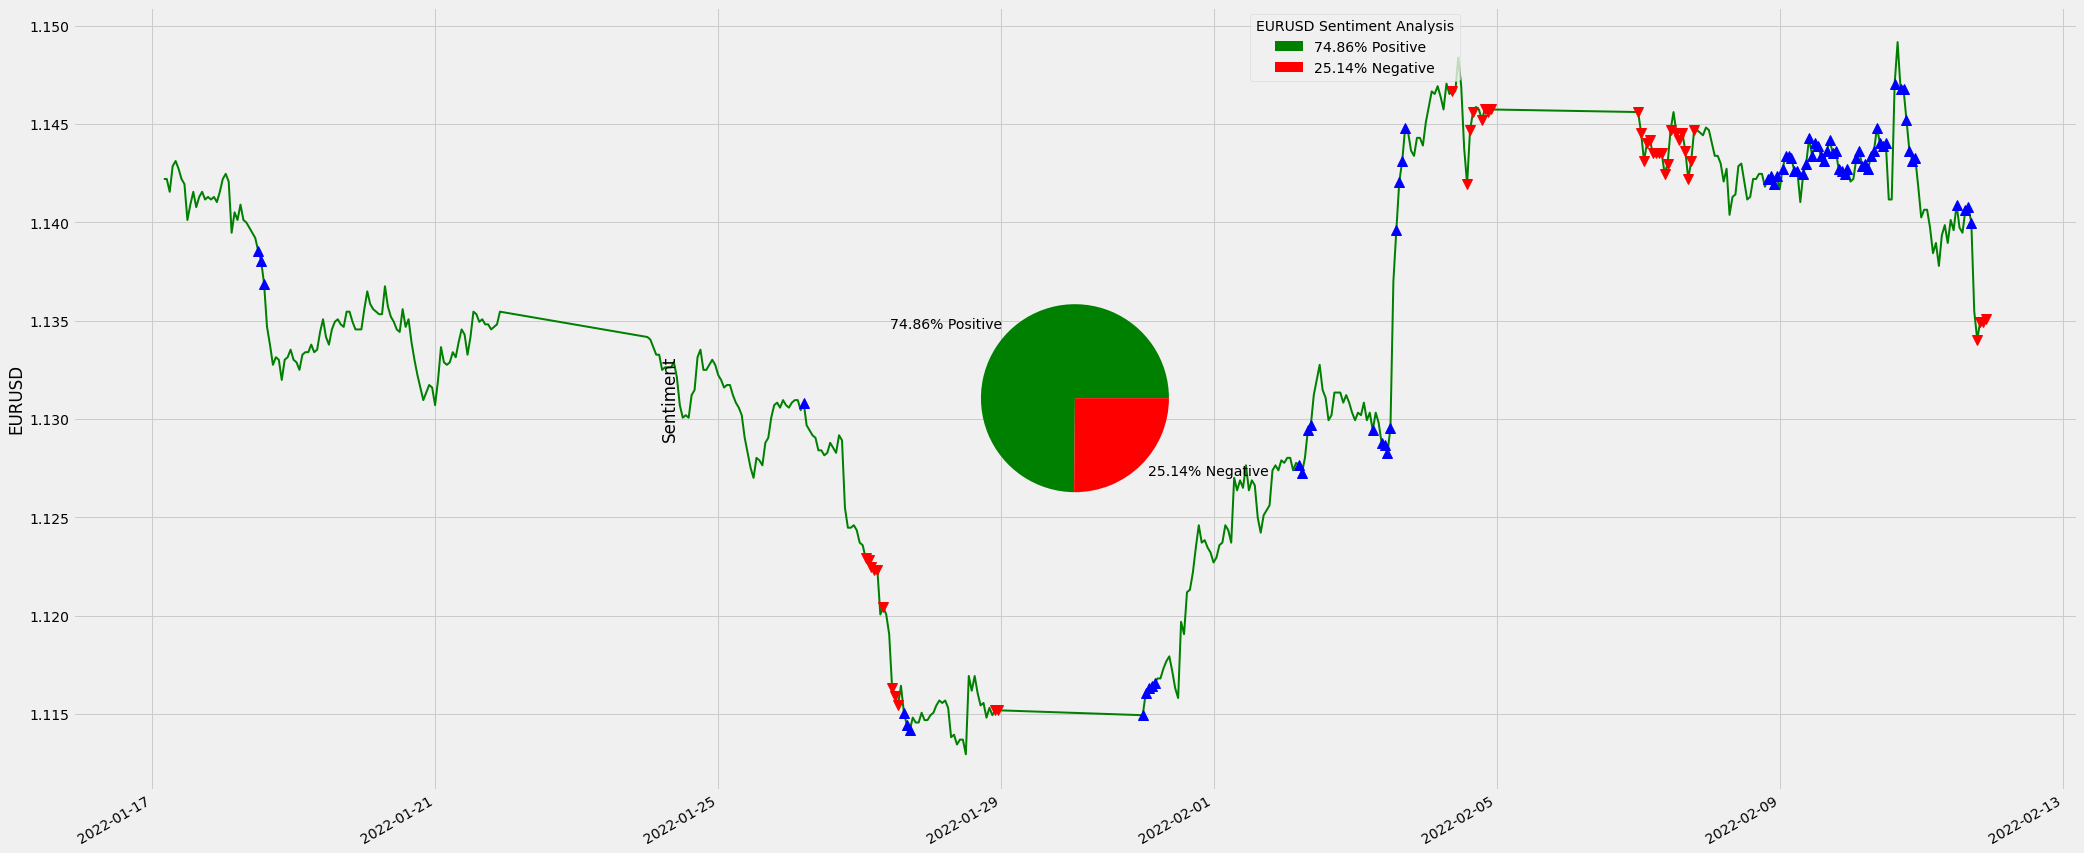

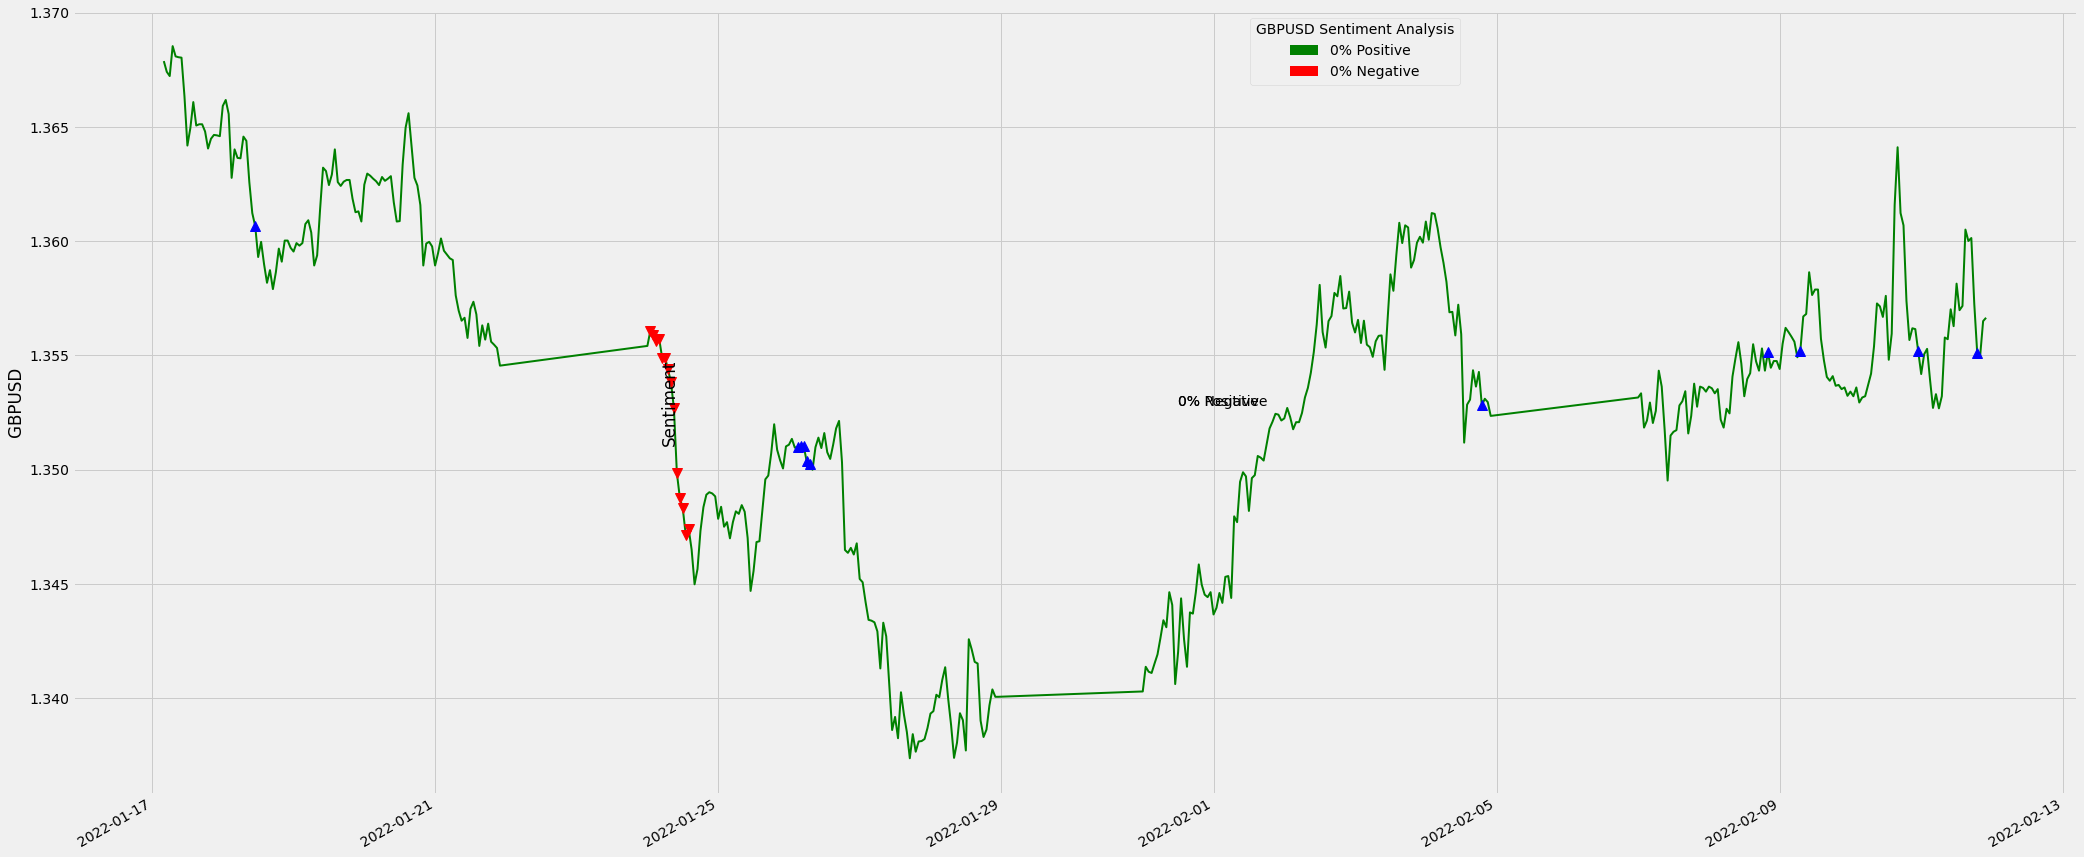

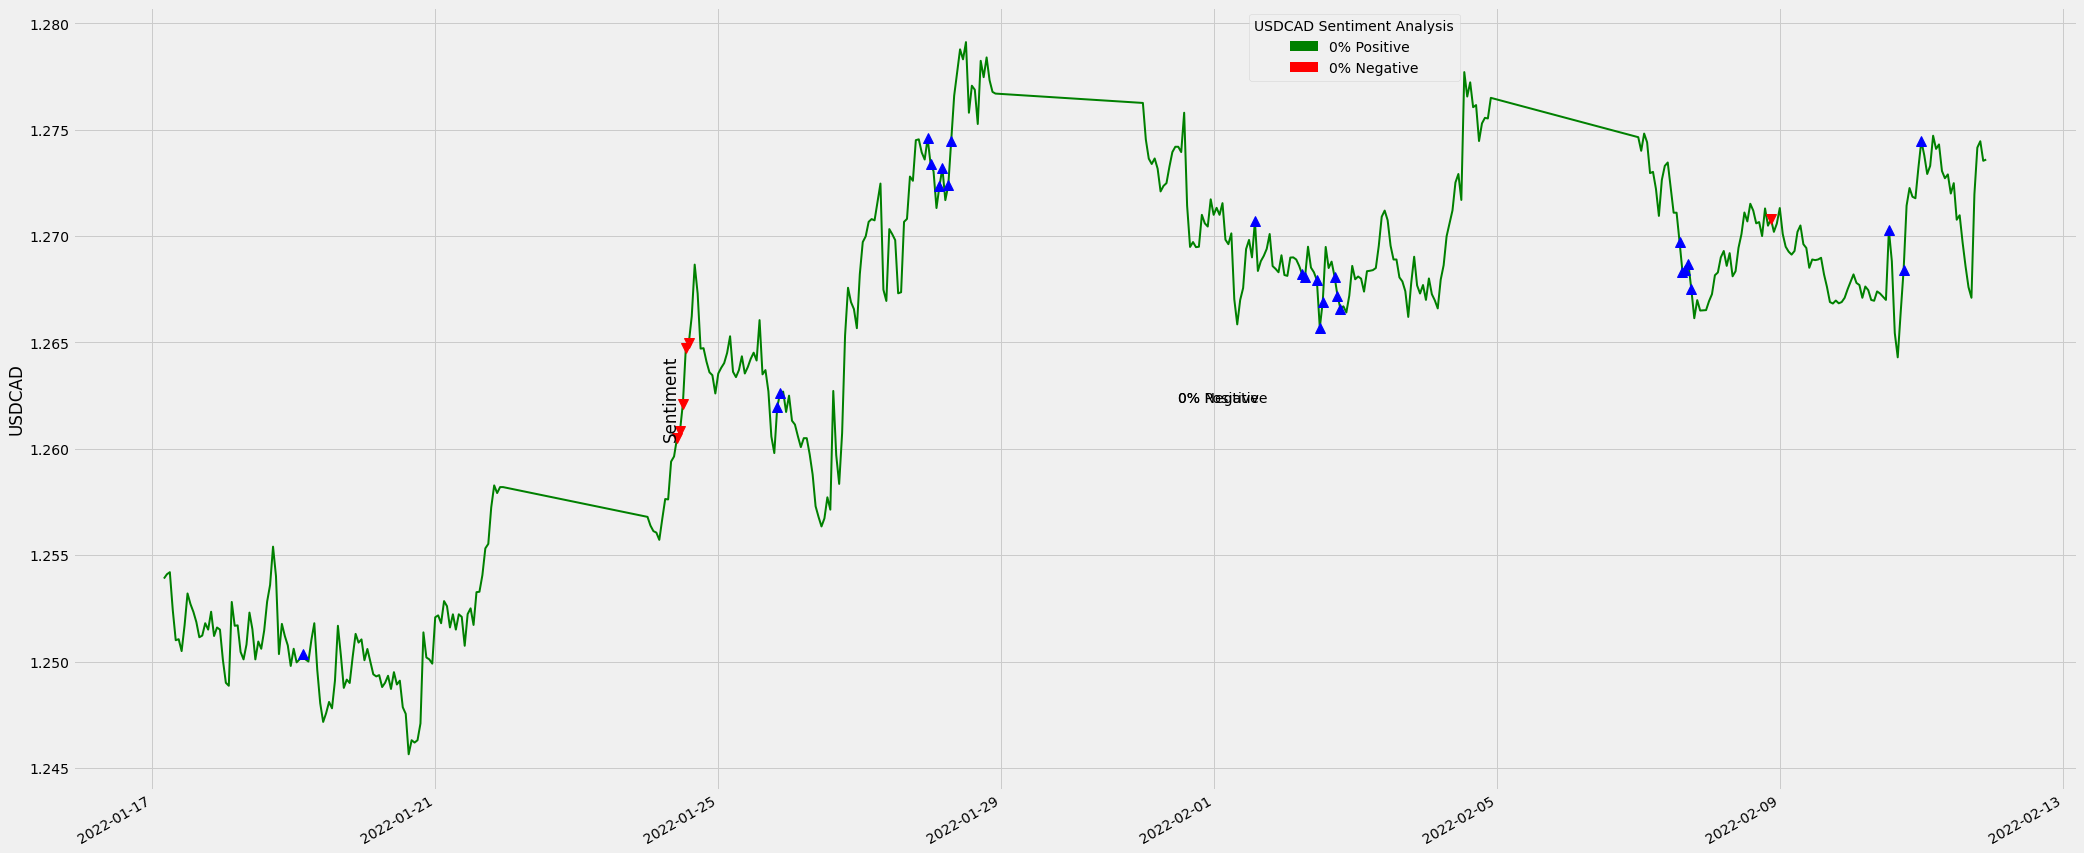

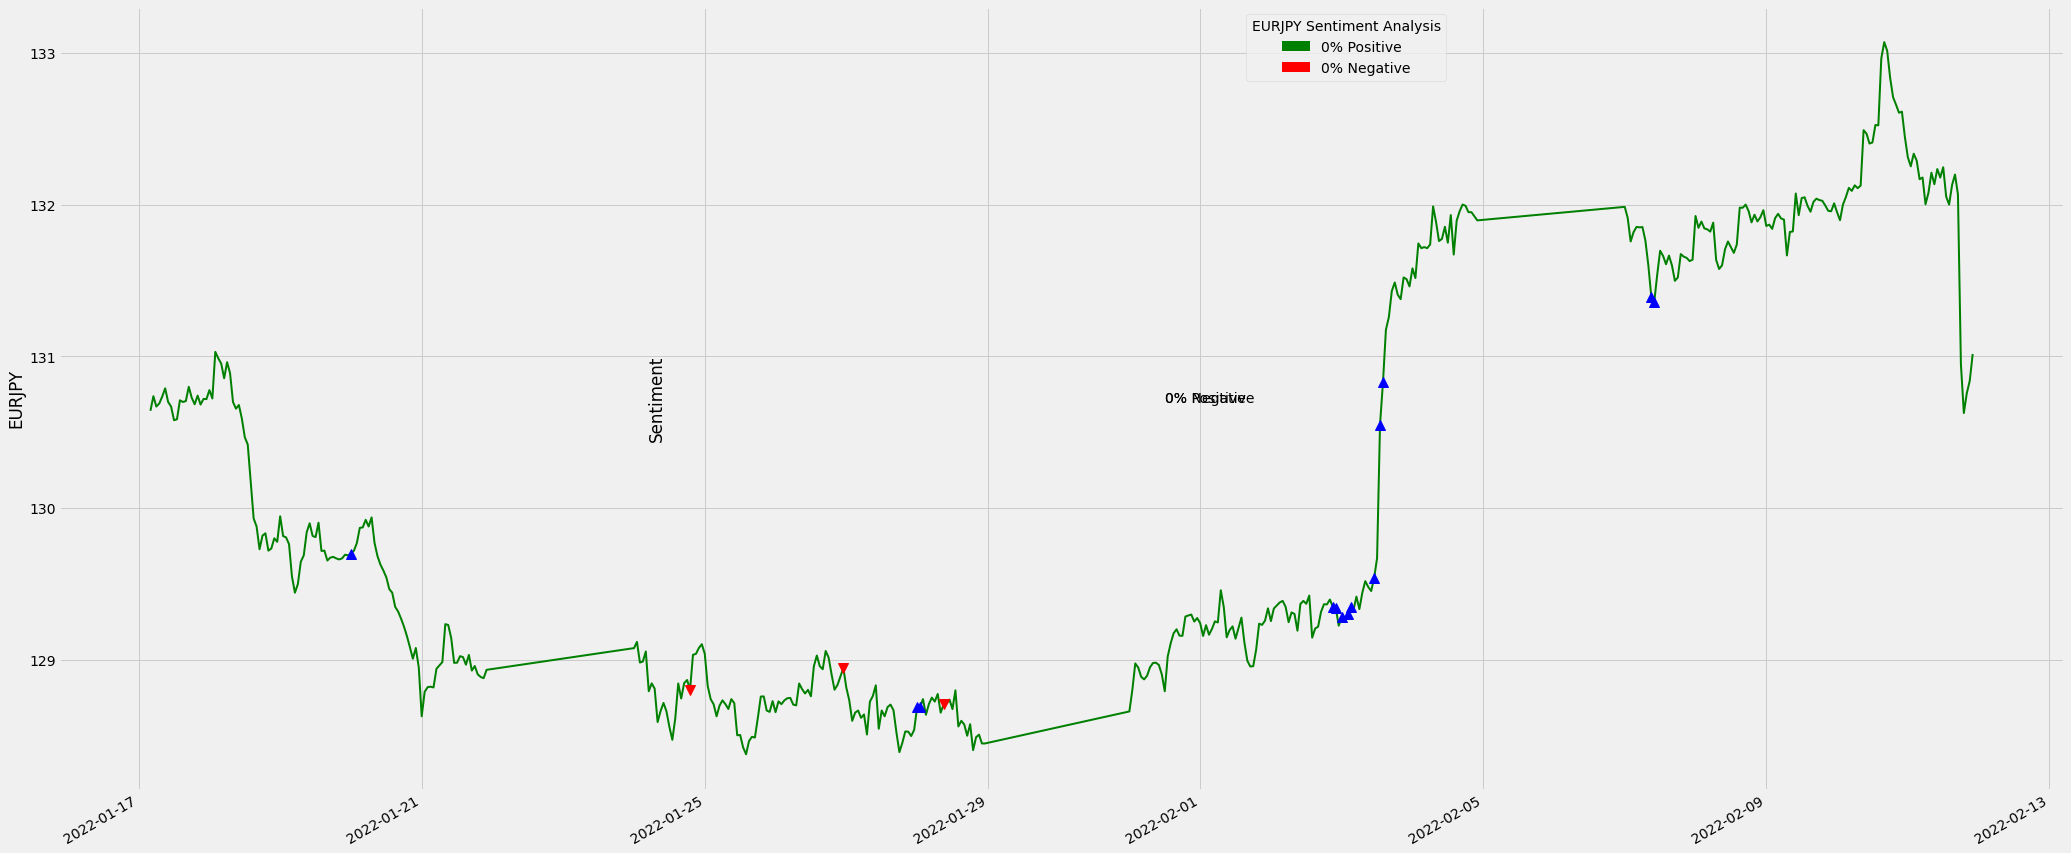

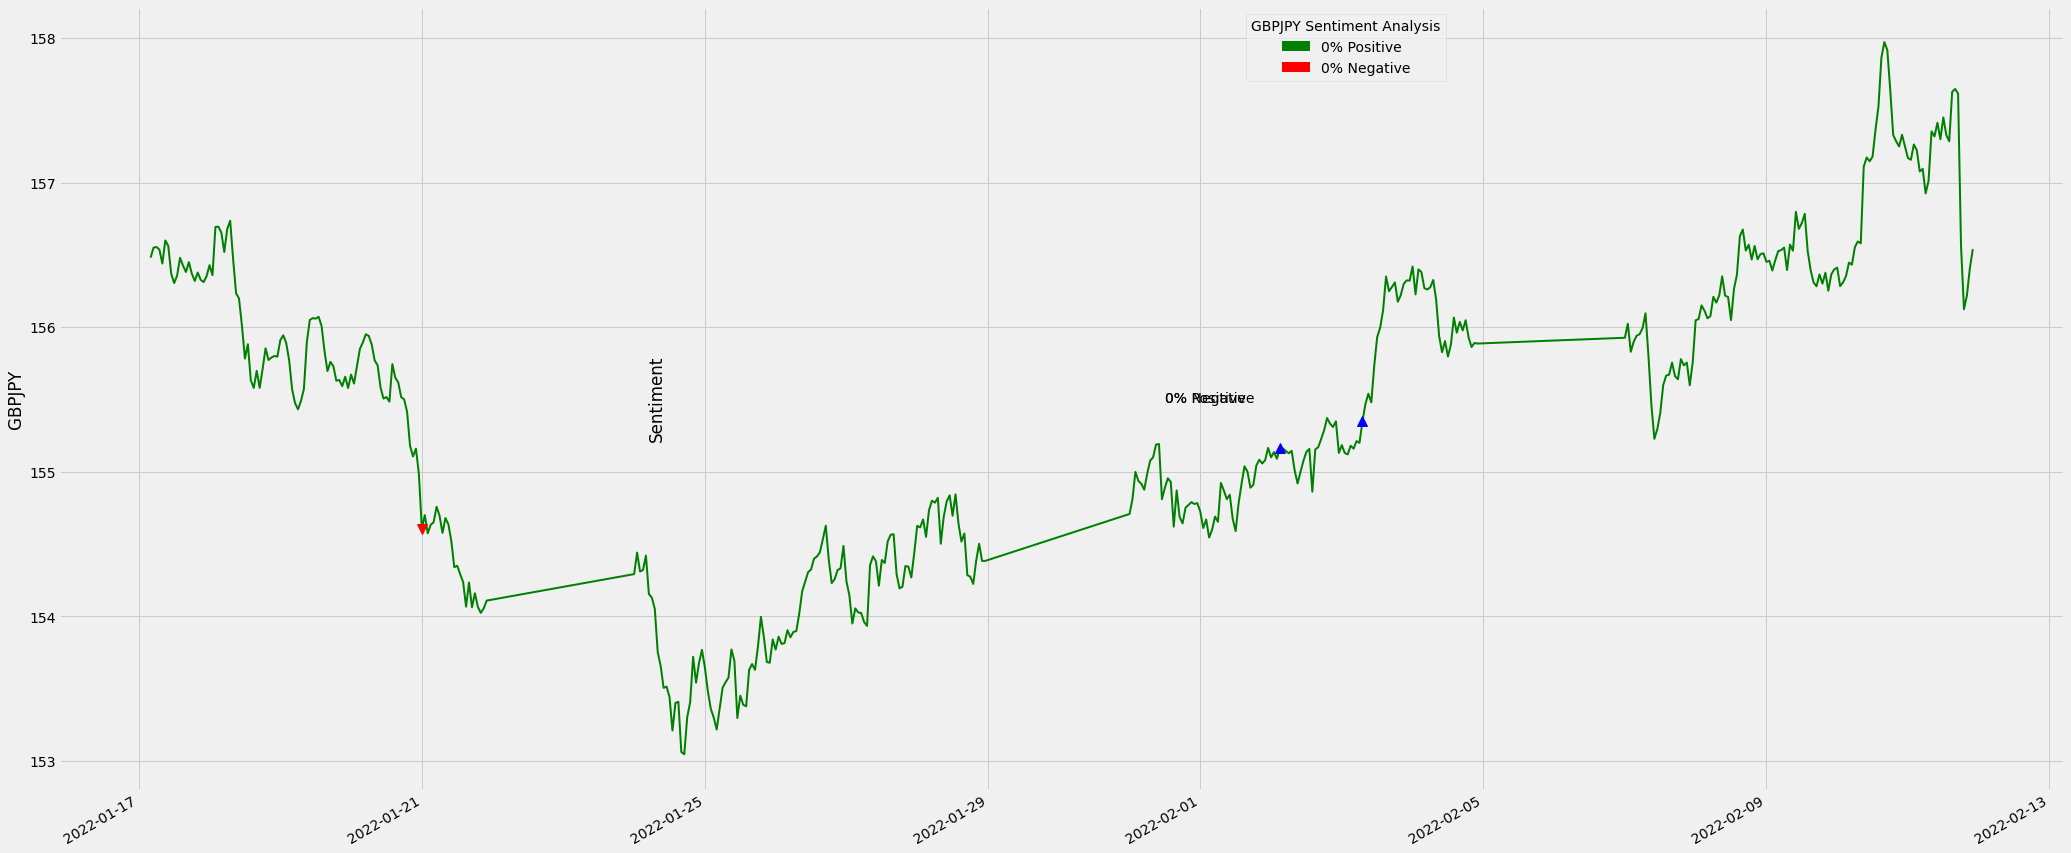

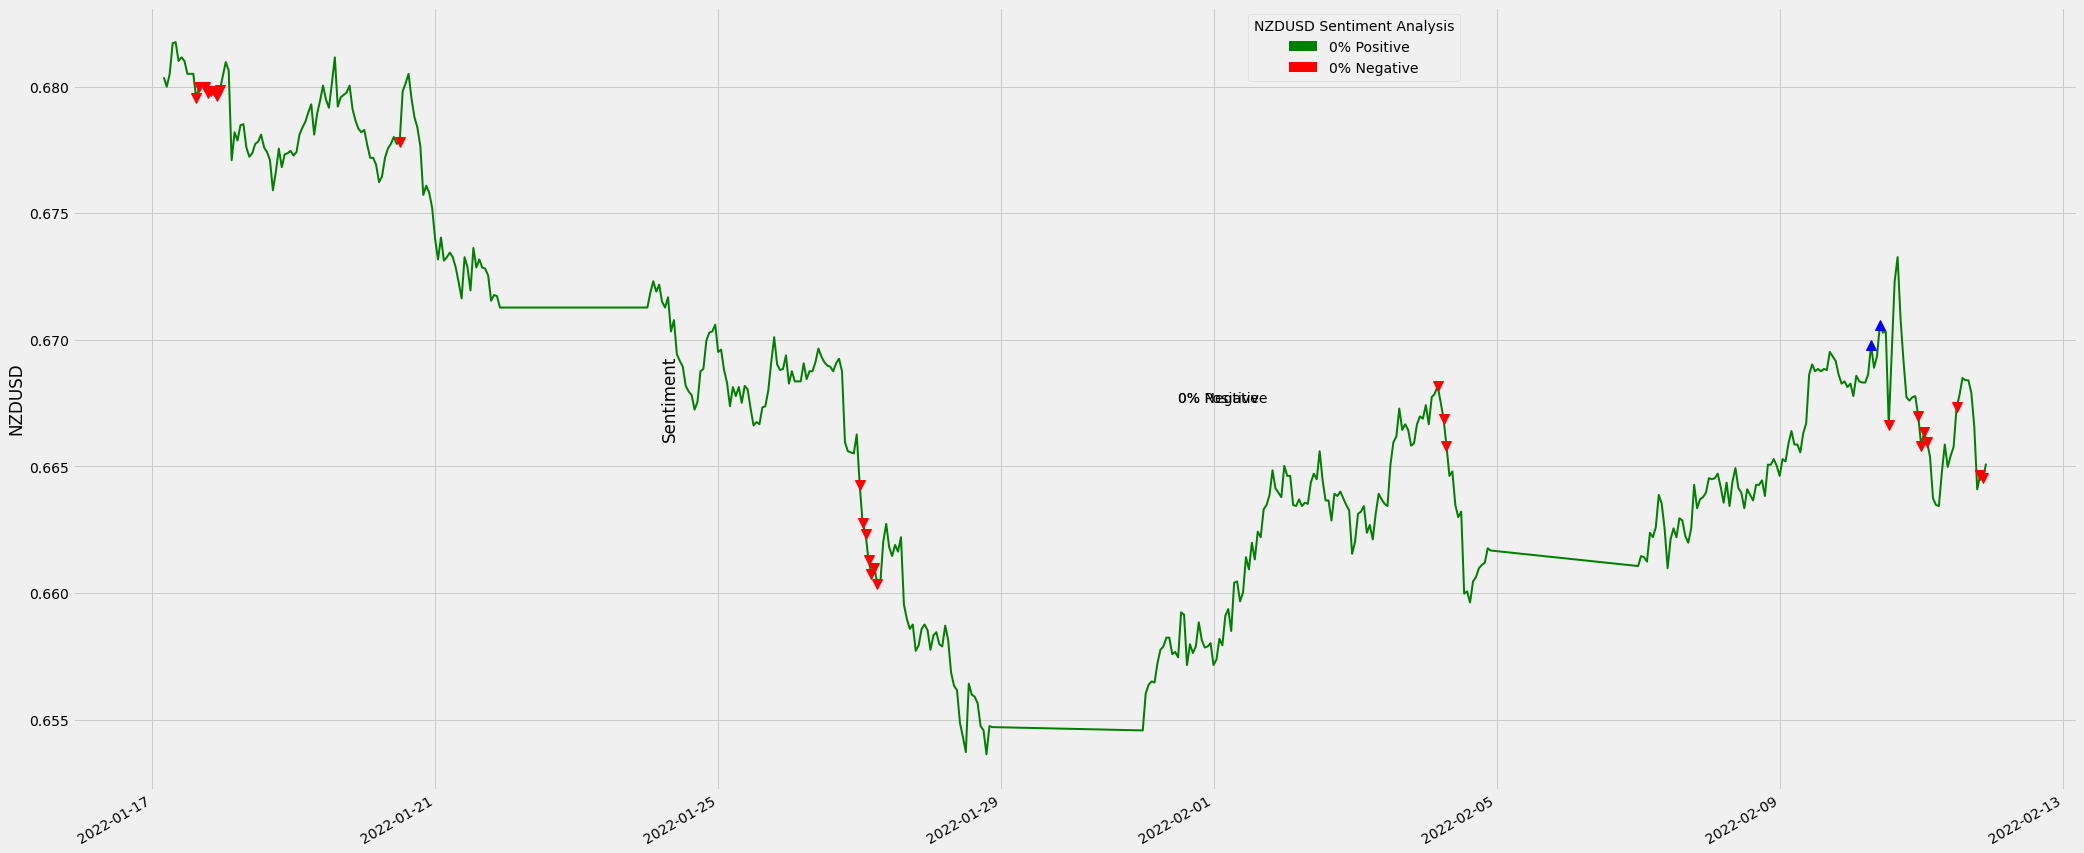

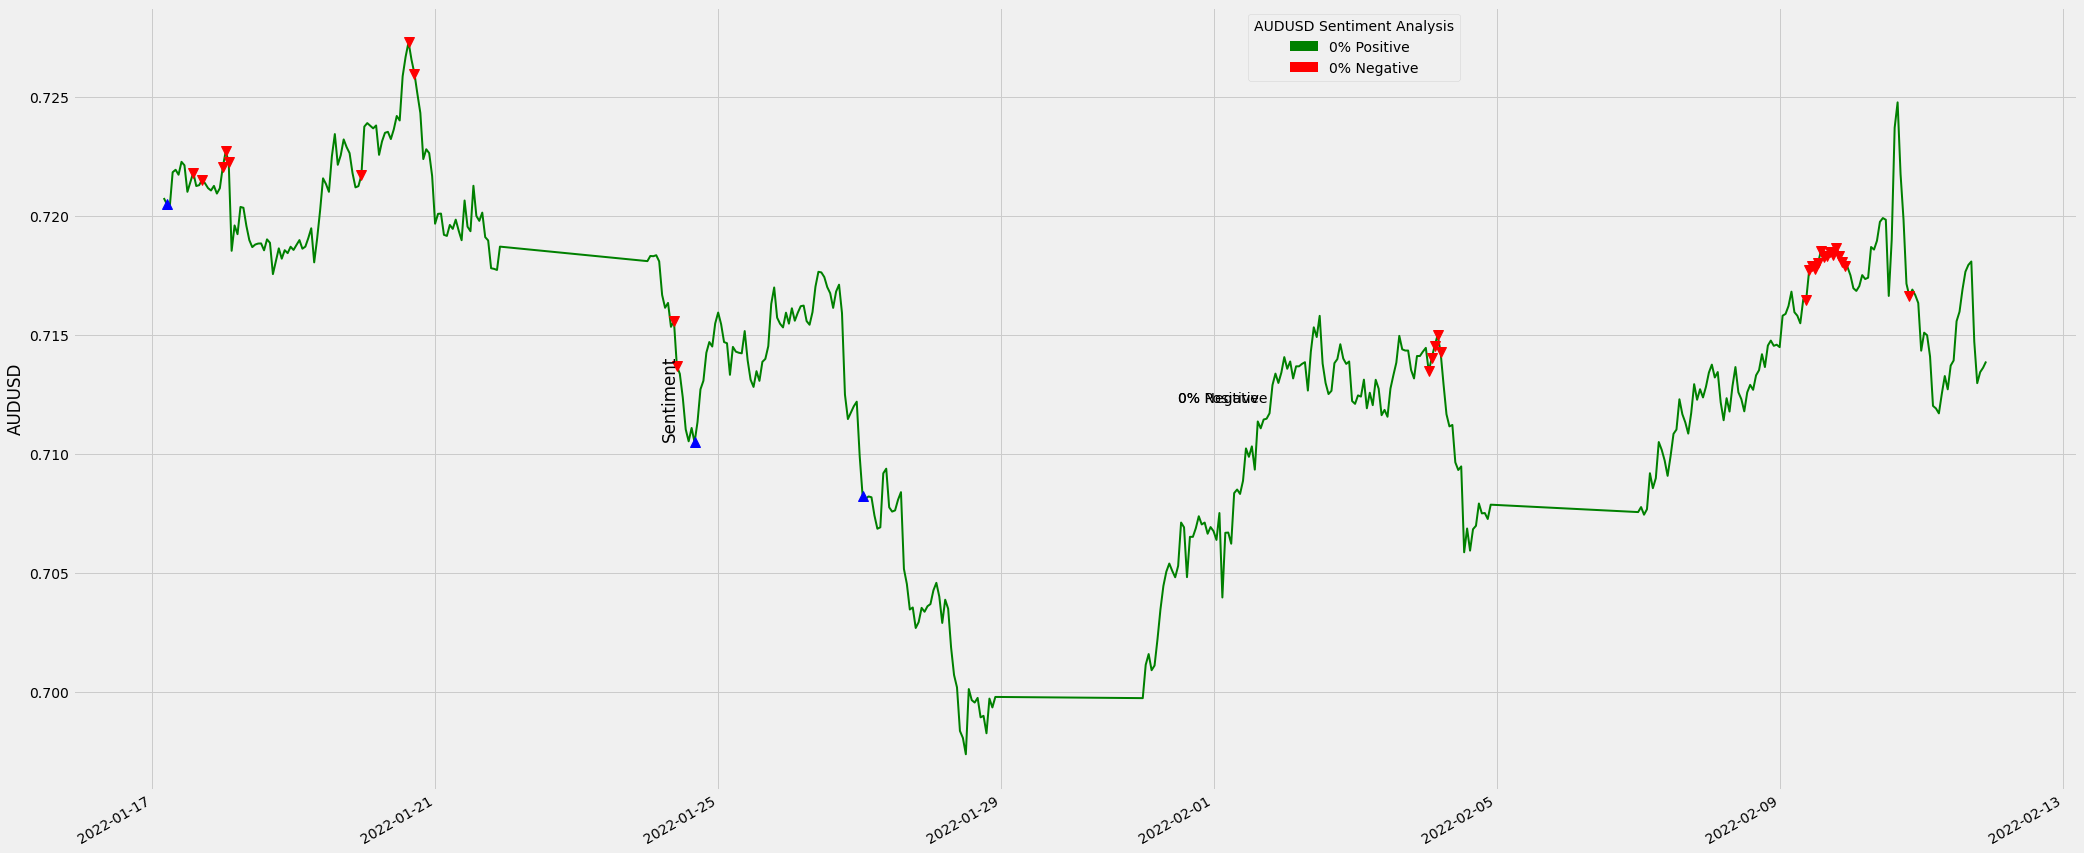

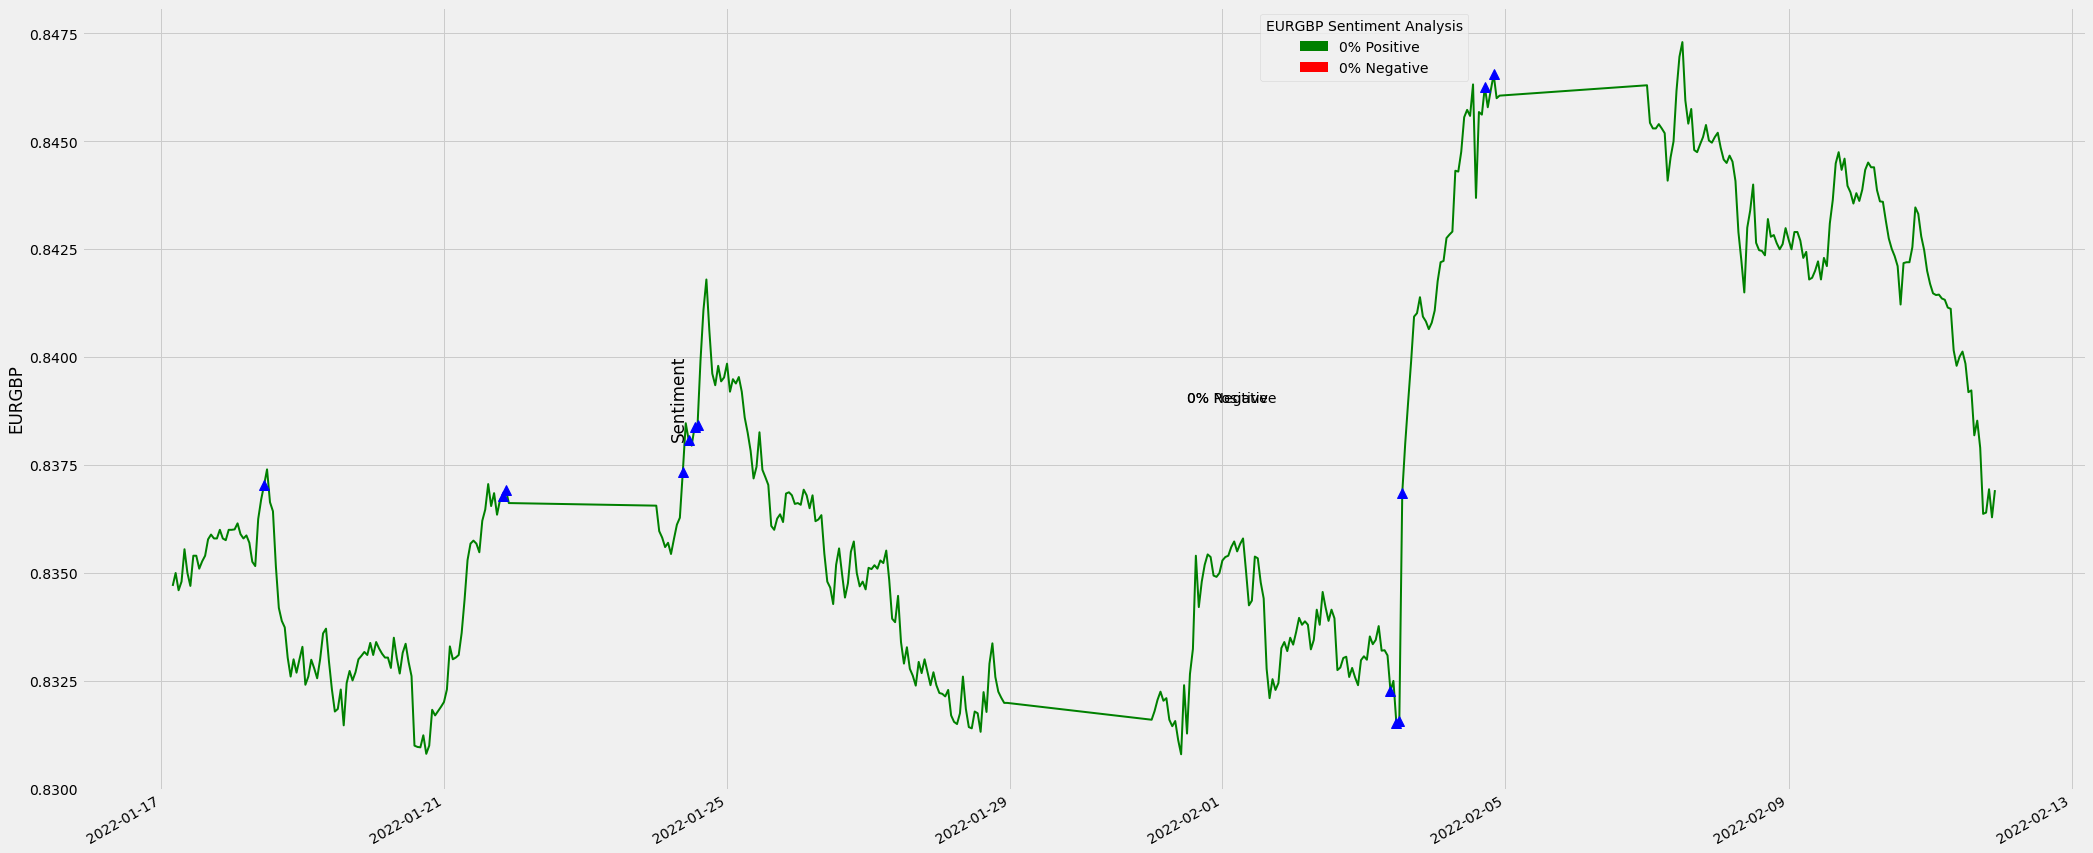

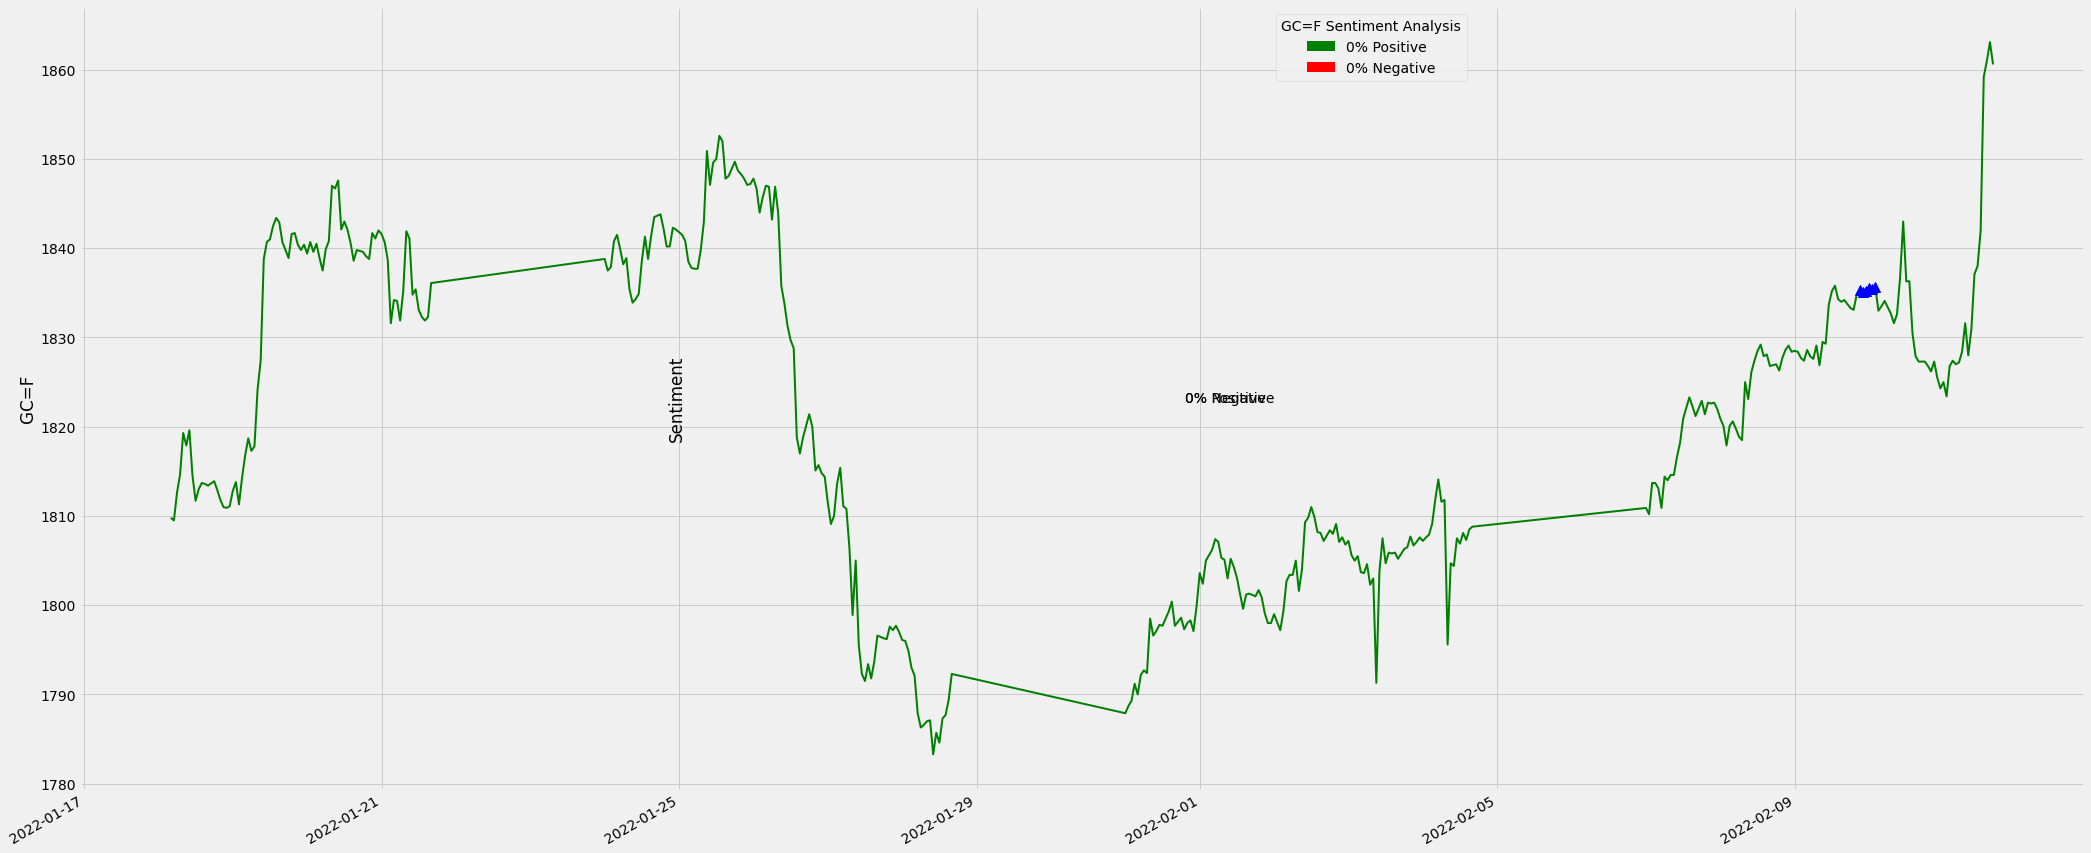

In [29]:
# download the max latest 30mn EURUSD dataframe
for symbol in symbols:
  predict(symbol)